In [1]:
import pandas as pd

# Change path to your file
EXCEL_PATH = "C:\\Users\\Aman Bisen\\Desktop\\dataset_instagram-scraper_2025-11-02_10-48-24-021.xlsx"

# Load the Excel file (shows sheets if multiple)
xls = pd.ExcelFile(EXCEL_PATH, engine='openpyxl')
print("Sheets:", xls.sheet_names)

# Load the first sheet by default; change sheet_name if needed
df = pd.read_excel(EXCEL_PATH, sheet_name=xls.sheet_names[0], engine='openpyxl')

# Display first 10 rows and shape of the dataframe
print(df.head(10))
print("Shape of DataFrame:", df.shape)


Sheets: ['Data']
                                             Comment
0                                                NaN
1                              Hair colour please???
2                                    You are glowing
3  Don't purchase anything from nykaa if you valu...
4                                                NaN
5                          How to be a part of this?
6  Hey @mynykaa ! Thank you so much for launching...
7                                     Gonna try this
8                                  black friday sale
9                           1599/-(Hope it's right )
Shape of DataFrame: (157, 1)


In [9]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def safe_nltk_setup():
    """Try to download punkt and stopwords; return booleans whether they are available."""
    punkt_ok = True
    stopwords_ok = True
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        try:
            nltk.download('punkt', quiet=True)
            nltk.data.find('tokenizers/punkt')
        except Exception:
            punkt_ok = False

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        try:
            nltk.download('stopwords', quiet=True)
            nltk.data.find('corpora/stopwords')
        except Exception:
            stopwords_ok = False

    return punkt_ok, stopwords_ok

# fallback simple tokenizer & stopword list if nltk resources unavailable
FALLBACK_STOPWORDS = {
    "the","and","is","in","it","of","to","a","for","on","with","that","this","i","you","was",
    "are","my","we","they","be","as","at","by","an","from","or","have","has","but","not"
}

def fallback_tokenize(text):
    # remove non-alphanumeric except spaces, then split
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return [t for t in text.split() if t.strip()]

def preprocess_comments(file_path,
                        comment_column_name=None,
                        output_file_name='preprocessed_comments.xlsx',
                        keep_optional_columns=None):
    """
    Robust preprocessing for comments in an Excel file.
    - auto-detects comment column if comment_column_name is None
    - keep_optional_columns: list of extra column names to include if present
    """
    if keep_optional_columns is None:
        keep_optional_columns = ['childPosts/0/commentsCount']

    try:
        # load excel (explicit engine to avoid engine-related errors)
        df = pd.read_excel(file_path, engine='openpyxl')
        print(f"Loaded file: {file_path}  (shape: {df.shape})")
    except FileNotFoundError:
        print(f"Error: file not found -> {file_path}")
        return
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return

    # try to auto-detect comment column if not provided
    possible_names = ['comment', 'comments', 'caption', 'text', 'message', 'reply']
    if comment_column_name is None:
        found = [c for c in df.columns if c.lower() in possible_names]
        if found:
            comment_column = found[0]
            print(f"Auto-detected comment column: '{comment_column}'")
        else:
            # try contains
            contains = [c for c in df.columns if any(p in c.lower() for p in possible_names)]
            if contains:
                comment_column = contains[0]
                print(f"Auto-detected comment-like column: '{comment_column}'")
            else:
                print("Error: Could not find a comment column automatically. Columns in file:")
                print(list(df.columns))
                return
    else:
        if comment_column_name not in df.columns:
            print(f"Error: specified column '{comment_column_name}' not in dataframe columns.")
            print("Available columns:", list(df.columns))
            return
        comment_column = comment_column_name

    # setup nltk resources
    punkt_ok, stopwords_ok = safe_nltk_setup()
    if punkt_ok:
        tokenizer = lambda txt: word_tokenize(txt)
    else:
        print("Warning: NLTK punkt tokenizer not available — using fallback tokenizer.")
        tokenizer = fallback_tokenize

    if stopwords_ok:
        stop_words = set(stopwords.words('english'))
    else:
        print("Warning: NLTK stopwords not available — using small fallback stopword set.")
        stop_words = FALLBACK_STOPWORDS

    # keep only rows where comment column not null/empty
    df = df.copy()
    df[comment_column] = df[comment_column].astype(str)  # cast everything to string safely
    df = df[df[comment_column].str.strip().astype(bool)].reset_index(drop=True)
    print(f"Rows with non-empty comments: {len(df)}")

    # new columns
    df['original_comment'] = df[comment_column]
    df['comment_lowercase'] = df['original_comment'].str.lower()

    # remove special characters except spaces and alnum
    df['comment_no_special_chars'] = df['comment_lowercase'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x))

    # tokenize safely (wrap in try to avoid unexpected tokenization errors)
    def safe_tokenize(x):
        try:
            return tokenizer(x)
        except Exception:
            return fallback_tokenize(x)

    df['comment_tokenized'] = df['comment_no_special_chars'].apply(safe_tokenize)

    # remove stopwords (again ensure lowercase)
    df['comment_no_stopwords'] = df['comment_tokenized'].apply(lambda tokens: [t for t in tokens if t.lower() not in stop_words])

    # join back to strings
    df['comment_tokenized_str'] = df['comment_tokenized'].apply(lambda tokens: ' '.join(tokens))
    df['comment_no_stopwords_str'] = df['comment_no_stopwords'].apply(lambda tokens: ' '.join(tokens))

    # select final columns (include optional ones if present)
    final_cols = [comment_column, 'original_comment', 'comment_lowercase',
                  'comment_no_special_chars', 'comment_tokenized_str', 'comment_no_stopwords_str']
    for oc in keep_optional_columns:
        if oc in df.columns:
            final_cols.append(oc)

    df_final = df[final_cols]

    # write output (use openpyxl engine)
    try:
        df_final.to_excel(output_file_name, index=False, engine='openpyxl')
        print(f"Preprocessing complete. Output saved to: {output_file_name}")
    except Exception as e:
        print(f"Error saving output Excel: {e}")
        # try save without specifying engine
        try:
            df_final.to_excel(output_file_name, index=False)
            print(f"Saved output to {output_file_name} (without engine param)")
        except Exception as e2:
            print(f"Failed to save output file: {e2}")

    # show top rows for quick check
    print(df_final.head(5))
    return df_final

# ----------- Example usage -----------
if __name__ == "__main__":
    input_excel_file = r"C:\Users\Aman Bisen\Desktop\dataset_instagram-scraper_2025-11-02_10-48-24-021.xlsx"
    output_excel_file = "nykaa11_comments_preprocessed.xlsx"
    preprocess_comments(input_excel_file, comment_column_name=None, output_file_name=output_excel_file)

Loaded file: C:\Users\Aman Bisen\Desktop\dataset_instagram-scraper_2025-11-02_10-48-24-021.xlsx  (shape: (157, 1))
Auto-detected comment column: 'Comment'
Rows with non-empty comments: 157
Preprocessing complete. Output saved to: nykaa11_comments_preprocessed.xlsx
                                             Comment  \
0                                                nan   
1                              Hair colour please???   
2                                    You are glowing   
3  Don't purchase anything from nykaa if you valu...   
4                                                nan   

                                    original_comment  \
0                                                nan   
1                              Hair colour please???   
2                                    You are glowing   
3  Don't purchase anything from nykaa if you valu...   
4                                                nan   

                                   comment_lowercase  \
0    

In [10]:
import pandas as pd
from textblob import TextBlob

# --- Step 1: PLEASE VERIFY THESE TWO VARIABLES ---
# Make sure this is the EXACT name of your preprocessed file.
# Common names might be 'preprocessed_google_play_reviews.xlsx' or 'preprocessed_google_play_reviews_optimized.xlsx'
input_file_name = 'nykaa11_comments_preprocessed.xlsx'

# Make sure this is the EXACT name of the column with the cleaned text.
# Common names might be 'text_no_stopwords_str' or 'review_no_stopwords'
column_to_analyze = 'comment_no_stopwords_str'

# This will be the name of your final output file.
output_file_name = 'reviews11_with_sentiment.xlsx'


# --- Step 2: Run the Analysis ---
try:
    # Load the preprocessed Excel file
    df = pd.read_excel(input_file_name)
    print(f"Successfully loaded '{input_file_name}'. Shape: {df.shape}")

    # --- Data Validation ---
    # Check if the specified column exists before we do anything else
    if column_to_analyze not in df.columns:
        raise KeyError(f"The column '{column_to_analyze}' was not found in your file.")

    # IMPORTANT: Ensure the column is treated as text (string).
    # This prevents errors if a cell contains numbers or is empty.
    df[column_to_analyze] = df[column_to_analyze].astype(str)
    print(f"Ready to analyze the content of the '{column_to_analyze}' column.")

    # --- Sentiment Analysis Functions ---
    def get_sentiment_score(text):
        """Calculates sentiment polarity score using TextBlob."""
        return TextBlob(text).sentiment.polarity

    def get_sentiment_category(score):
        """Categorizes the sentiment based on the polarity score."""
        if score > 0.05:  # A small threshold to be more confidently positive
            return 'Positive'
        elif score < -0.05: # A small threshold to be more confidently negative
            return 'Negative'
        else:
            return 'Neutral'

    # --- Apply Functions to the DataFrame ---
    # Create the 'sentiment_score' column by applying the function to our target column
    df['sentiment_score'] = df[column_to_analyze].apply(get_sentiment_score)
    print("Sentiment scores have been calculated.")

    # Create the 'sentiment_category' column
    df['sentiment_category'] = df['sentiment_score'].apply(get_sentiment_category)
    print("Sentiment categories have been assigned.")

    # --- Save the Final Results ---
    df.to_excel(output_file_name, index=False)
    print(f"\nSUCCESS! Analysis complete. The new file is saved as '{output_file_name}'.")

    # --- Display a Preview ---
    print("\nHere is a preview of your results:")
    # We show the column we analyzed plus the two new columns
    print(df[[column_to_analyze, 'sentiment_score', 'sentiment_category']].head())

    print("\nSummary of sentiment distribution:")
    print(df['sentiment_category'].value_counts())

except FileNotFoundError:
    print(f"--- ERROR: File Not Found ---")
    print(f"The file named '{input_file_name}' was not found.")
    print("TROUBLESHOOTING: Please check that the file name is spelled correctly and that it is in the same folder as your Jupyter Notebook.")

except KeyError as e:
    print(f"--- ERROR: Column Not Found ---")
    print(f"{e}")
    print("TROUBLESHOOTING: Please check that the variable 'column_to_analyze' exactly matches a column name in your Excel file.")
    print("\nHere are the actual column names in your file:")
    # This will print the list of available columns to help you find the correct one
    print(df.columns.tolist())

except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'nykaa11_comments_preprocessed.xlsx'. Shape: (157, 6)
Ready to analyze the content of the 'comment_no_stopwords_str' column.
Sentiment scores have been calculated.
Sentiment categories have been assigned.

SUCCESS! Analysis complete. The new file is saved as 'reviews11_with_sentiment.xlsx'.

Here is a preview of your results:
                            comment_no_stopwords_str  sentiment_score  \
0                                                nan              0.0   
1                                 hair colour please              0.0   
2                                            glowing              0.0   
3  purchase anything nykaa value money scamming c...              0.0   
4                                                nan              0.0   

  sentiment_category  
0            Neutral  
1            Neutral  
2            Neutral  
3            Neutral  
4            Neutral  

Summary of sentiment distribution:
sentiment_category
Neutral     118
Posi

Successfully loaded 'reviews11_with_sentiment.xlsx'.

Counts of each sentiment category:
sentiment_category
Neutral     118
Positive     20
Negative     19
Name: count, dtype: int64


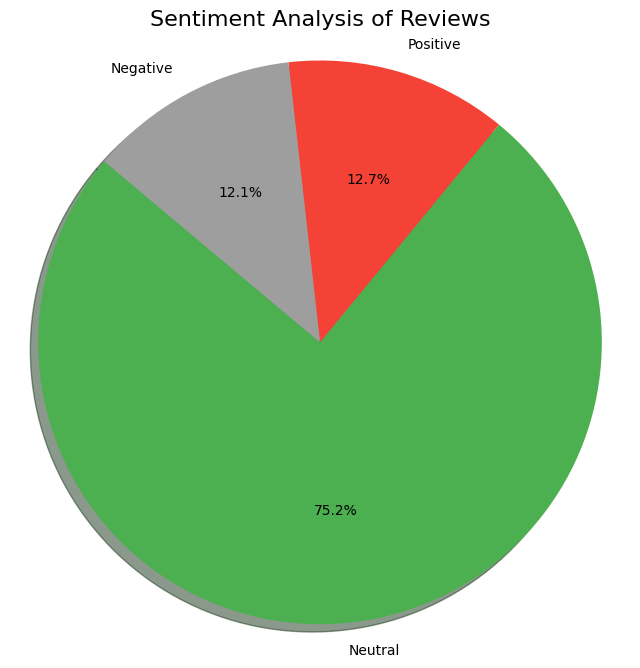

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
# This should be the name of the file you just created with the sentiment scores
input_file_name = 'reviews11_with_sentiment.xlsx'
# This is the column we want to visualize
column_to_plot = 'sentiment_category'

try:
    # 1. Load the data from the Excel file
    df = pd.read_excel(input_file_name)
    print(f"Successfully loaded '{input_file_name}'.")

    # 2. Count the occurrences of each sentiment category
    # The .value_counts() method does this for us and is perfect for plotting
    sentiment_counts = df[column_to_plot].value_counts()
    print("\nCounts of each sentiment category:")
    print(sentiment_counts)

    # --- 3. Create the Pie Chart ---

    # Set the figure size for better readability
    plt.figure(figsize=(8, 8))

    # Define custom colors to make the chart more intuitive
    colors = ['#4CAF50', '#F44336', '#9E9E9E'] # Green for Positive, Red for Negative, Grey for Neutral

    # Create the pie chart with labels, percentages, and custom colors
    plt.pie(sentiment_counts,
            labels=sentiment_counts.index,
            autopct='%1.1f%%',
            startangle=140,
            colors=colors,
            shadow=True)

    # Add a title to the chart
    plt.title('Sentiment Analysis of Reviews', fontsize=16)

    # Ensure the pie chart is a circle
    plt.axis('equal')

    # Display the chart
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{input_file_name}' was not found. Please ensure the file name is correct and it's in the same directory.")
except KeyError:
    print(f"Error: The column '{column_to_plot}' was not found in the file. Please check the column names in your Excel file.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded 'reviews11_with_sentiment.xlsx'.
Running topic modeling...
Topic modeling complete. Generating charts...


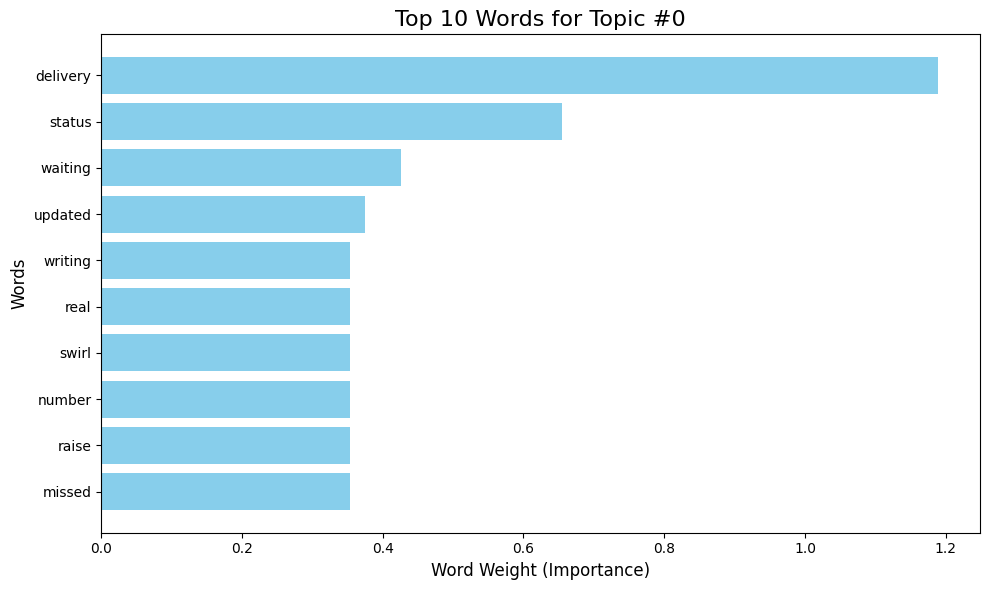

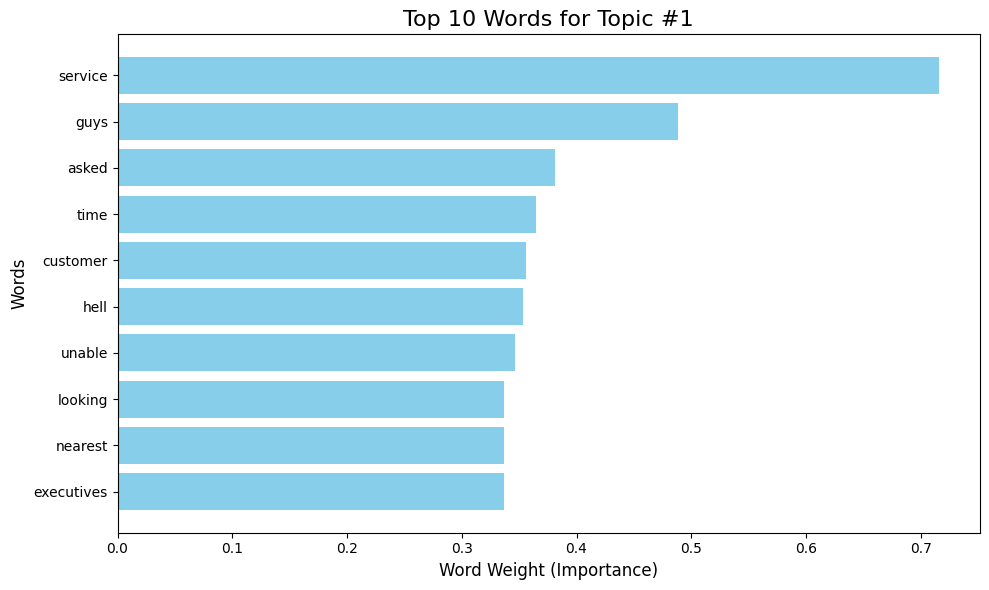

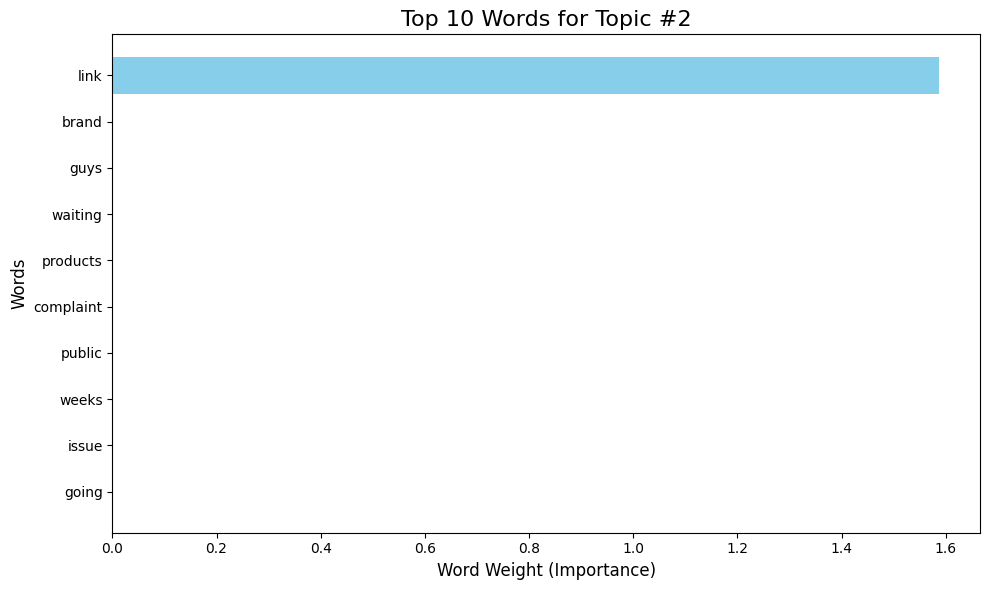

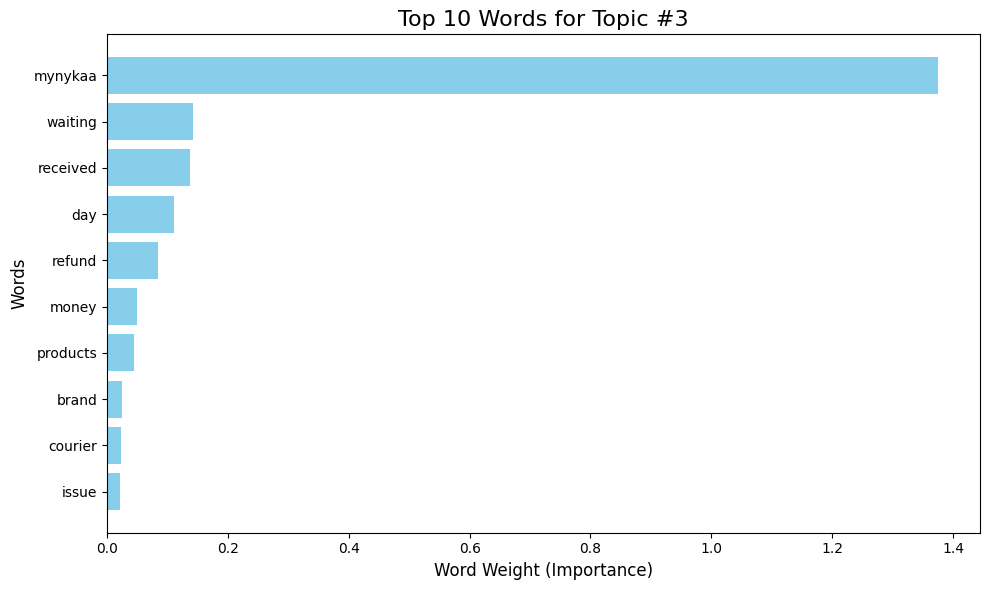

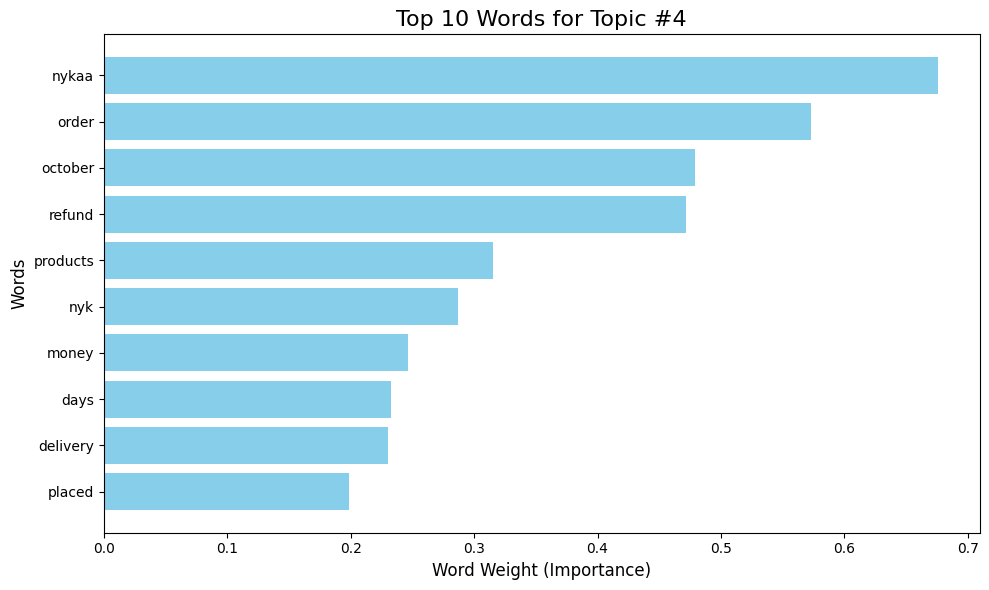

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# --- Step 1: Configuration ---
# This MUST be the exact name of your Excel file with sentiment data.
input_file_name = 'reviews11_with_sentiment.xlsx'

# This MUST be the exact name of the column with cleaned text.
column_to_analyze = 'comment_no_stopwords_str'

# The number of topics and top words to display in the charts.
num_topics = 5
num_top_words = 10


try:
    # --- Step 2: Load and Prepare Data ---
    df = pd.read_excel(input_file_name)
    print(f"Successfully loaded '{input_file_name}'.")

    # Validate and clean the data
    if column_to_analyze not in df.columns:
        raise KeyError(f"The column '{column_to_analyze}' was not found in your file.")
    df.dropna(subset=[column_to_analyze], inplace=True)
    text_data = df[column_to_analyze].astype(str)
    if text_data.empty:
        raise ValueError("The text data is empty after cleaning. Cannot proceed.")

    # --- Step 3: Vectorize and Run NMF (same as before) ---
    print("Running topic modeling...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    nmf_model = NMF(n_components=num_topics, random_state=42, init='nndsvda').fit(tfidf_matrix)
    print("Topic modeling complete. Generating charts...")

    # --- Step 4: Generate a Bar Chart for Each Topic ---
    for topic_idx, topic in enumerate(nmf_model.components_):
        # Get the indices of the top words for this topic
        top_word_indices = topic.argsort()[:-num_top_words - 1:-1]

        # Get the top words and their corresponding weights
        top_words = [tfidf_feature_names[i] for i in top_word_indices]
        top_weights = [topic[i] for i in top_word_indices]

        # --- Create the plot ---
        plt.figure(figsize=(10, 6)) # Set the figure size
        
        # Create a horizontal bar chart
        plt.barh(top_words, top_weights, color='skyblue')
        
        # Invert the y-axis so the most important word is at the top
        plt.gca().invert_yaxis()

        # Add titles and labels for clarity
        plt.title(f'Top {num_top_words} Words for Topic #{topic_idx}', fontsize=16)
        plt.xlabel('Word Weight (Importance)', fontsize=12)
        plt.ylabel('Words', fontsize=12)
        
        # Ensure the layout is tight so labels don't get cut off
        plt.tight_layout()
        
        # Display the plot
        plt.show()


except FileNotFoundError:
    print(f"--- ERROR: File Not Found ---")
    print(f"The file named '{input_file_name}' was not found.")
except KeyError as e:
    print(f"--- ERROR: Column Not Found ---")
    print(f"{e}")
    print("\nHere are the actual column names in your file:")
    print(pd.read_excel(input_file_name).columns.tolist())
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'reviews11_with_sentiment.xlsx'.
Running topic modeling...
Topic modeling complete. Generating word clouds...


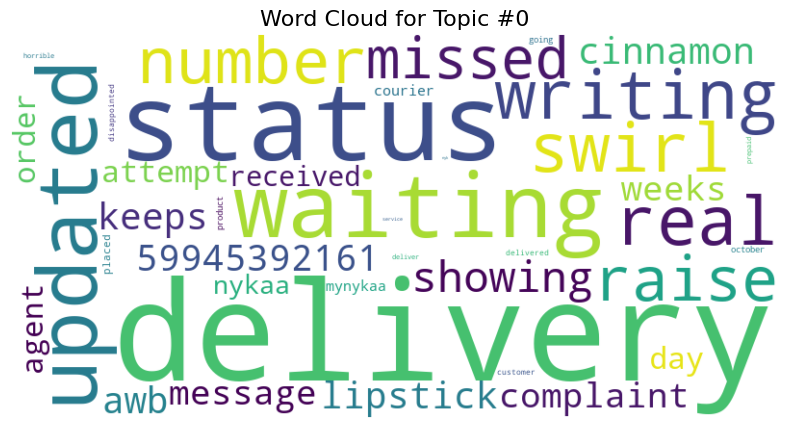

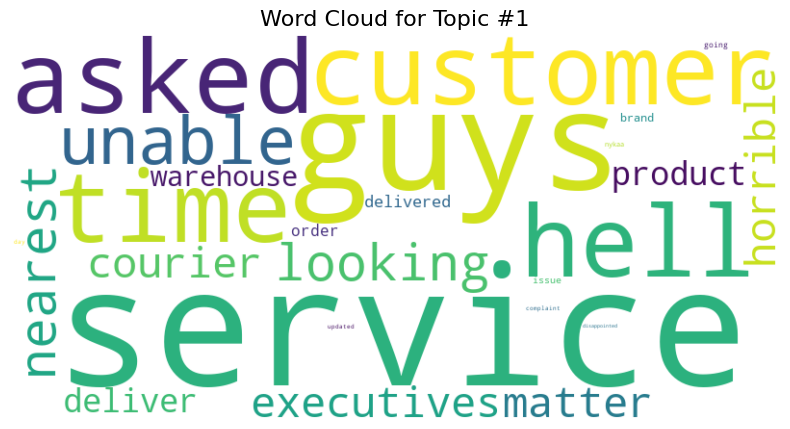

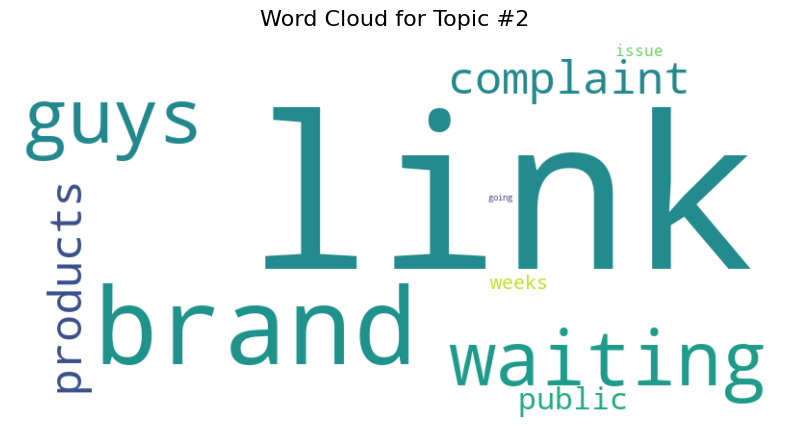

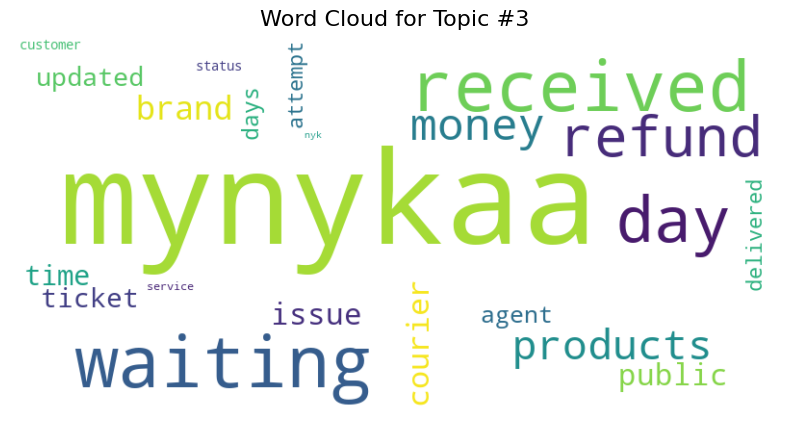

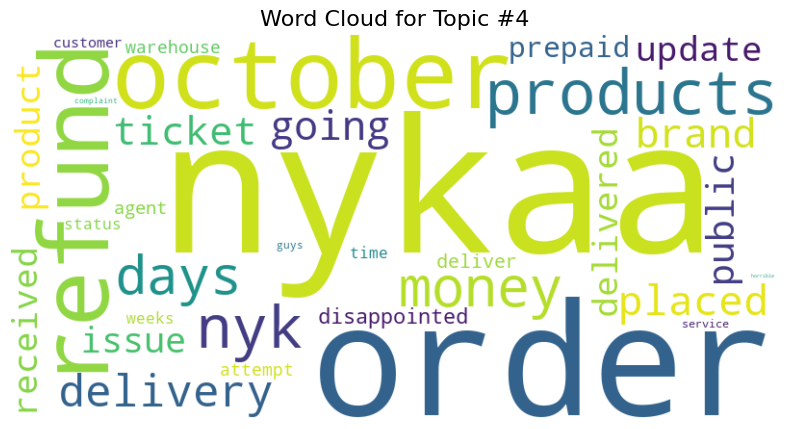

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud

# --- Step 1: Configuration ---
# This MUST be the exact name of your Excel file with sentiment data.
input_file_name = 'reviews11_with_sentiment.xlsx'

# This MUST be the exact name of the column with cleaned text.
column_to_analyze = 'comment_no_stopwords_str'

# The number of topics you want to find.
num_topics = 5


try:
    # --- Step 2: Load and Prepare Data ---
    df = pd.read_excel(input_file_name)
    print(f"Successfully loaded '{input_file_name}'.")

    # Validate and clean the data
    if column_to_analyze not in df.columns:
        raise KeyError(f"The column '{column_to_analyze}' was not found in your file.")
    df.dropna(subset=[column_to_analyze], inplace=True)
    text_data = df[column_to_analyze].astype(str)
    if text_data.empty:
        raise ValueError("The text data is empty after cleaning. Cannot proceed.")

    # --- Step 3: Vectorize and Run NMF (same as before) ---
    print("Running topic modeling...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    nmf_model = NMF(n_components=num_topics, random_state=42, init='nndsvda').fit(tfidf_matrix)
    print("Topic modeling complete. Generating word clouds...")

    # --- Step 4: Generate a Word Cloud for Each Topic ---

    # Get the vocabulary (list of words) from the vectorizer
    words = tfidf_vectorizer.get_feature_names_out()

    for topic_idx, topic in enumerate(nmf_model.components_):
        # Create a dictionary of words and their weights for the current topic
        # The WordCloud object expects frequencies, so we'll use the NMF component weights
        topic_words = {words[i]: topic[i] for i in topic.argsort()[:-51:-1]} # Get top 50 words

        # Create the WordCloud object
        wordcloud = WordCloud(width=800,
                              height=400,
                              background_color='white',
                              colormap='viridis').generate_from_frequencies(topic_words)

        # --- Plot the Word Cloud ---
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Topic #{topic_idx}', fontsize=16)
        plt.axis('off') # Hide the axes
        plt.show()


except FileNotFoundError:
    print(f"--- ERROR: File Not Found ---")
    print(f"The file named '{input_file_name}' was not found.")
except KeyError as e:
    print(f"--- ERROR: Column Not Found ---")
    print(f"{e}")
    print("\nHere are the actual column names in your file:")
    print(pd.read_excel(input_file_name).columns.tolist())
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [15]:
import pandas as pd
from collections import Counter
import re

# --- Load your data ---
df = pd.read_excel("reviews11_with_sentiment.xlsx")  # Replace with your file

# Ensure the column exists
ctext_column = "comment_no_stopwords_str"
if text_column not in df.columns:
    raise KeyError(f"Column '{text_column}' not found. Available columns: {df.columns.tolist()}")

# Combine all text into a single list of words
all_text = ' '.join(df[text_column].dropna().astype(str))
all_words = all_text.split()  # Split into individual words

# ------------------- Bigrams -------------------
bigrams_list = [tuple(all_words[i:i+2]) for i in range(len(all_words)-1)]
bigram_freq = Counter(bigrams_list)

print("=== Top 20 Bigrams ===")
for bg, freq in bigram_freq.most_common(20):
    print(f"{' '.join(bg)}: {freq}")

# ------------------- Trigrams -------------------
trigrams_list = [tuple(all_words[i:i+3]) for i in range(len(all_words)-2)]
trigram_freq = Counter(trigrams_list)

print("\n=== Top 20 Trigrams ===")
for tg, freq in trigram_freq.most_common(20):
    print(f"{' '.join(tg)}: {freq}")

NameError: name 'text_column' is not defined